In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


How to choose s

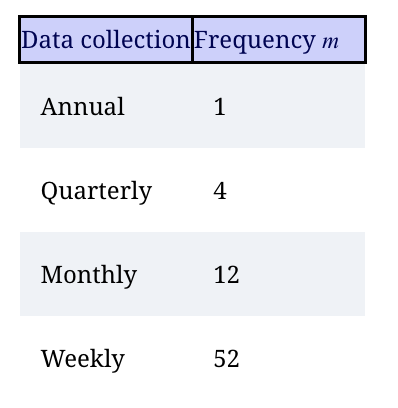
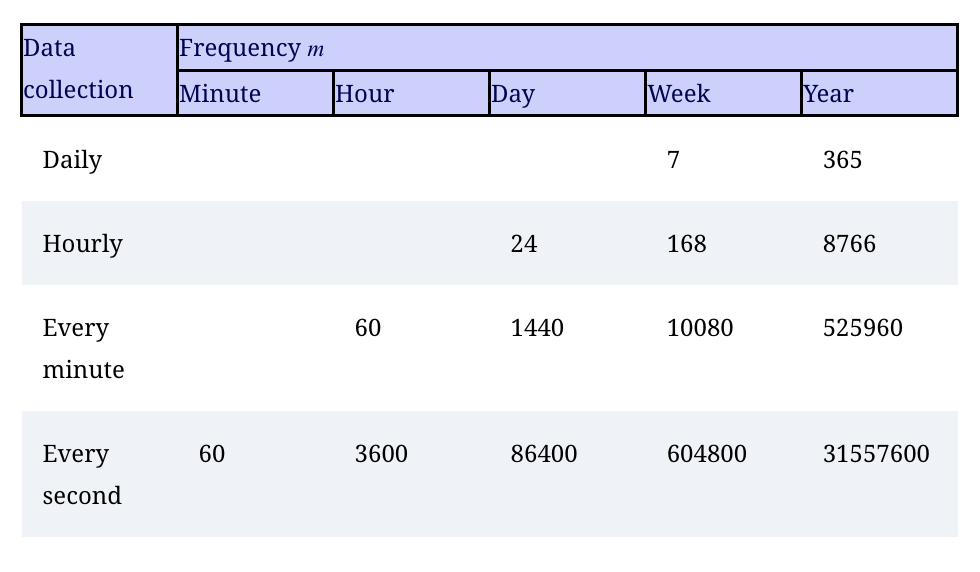

When data is collected on a daily or sub-daily basis, there are multiple ways of interpreting the frequency. For example, daily data can have a weekly seasonality. In that case, the frequency is m = 7 because there would be seven observations in a full cycle of 1 week. It could also have a yearly seasonality, meaning that m = 365. Thus, you can see that daily and sub-daily data can have a different cycle length, and therefore a different frequency m. 

In [16]:
data=pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/jj.csv")

In [17]:
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


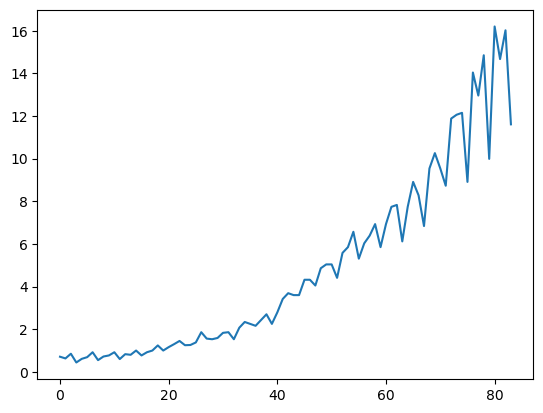

In [18]:
plt.plot(data['data'])

In [35]:
print(adfuller(data['data'])[0],adfuller(data['data'])[1])
diff_data=np.diff(data['data'],n=1)
print(adfuller(diff_data)[0],adfuller(diff_data)[1])
diff_data_2=np.diff(diff_data,n=1)
print(adfuller(diff_data_2)[0],adfuller(diff_data_2)[1])
#----------
df_diff_seasonal_diff = np.diff(data['data'], n=4)
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

2.7420165734574744 1.0
-0.40740976363804615 0.9088542416911305
-3.585162874793155 0.006051099869603682
ADF Statistic: -5.694683683218428
p-value: 7.923915826877299e-07


From the above we can understand that at the 2nd order diff we can reject the null hypothysis so d=2 or in the 2nd step we can apply the seasonal differencing

from the above we can tell that either we can apply (d=2) or (D=1 and d=1)

what we can do is we will apply ARIMA and  SARIMA

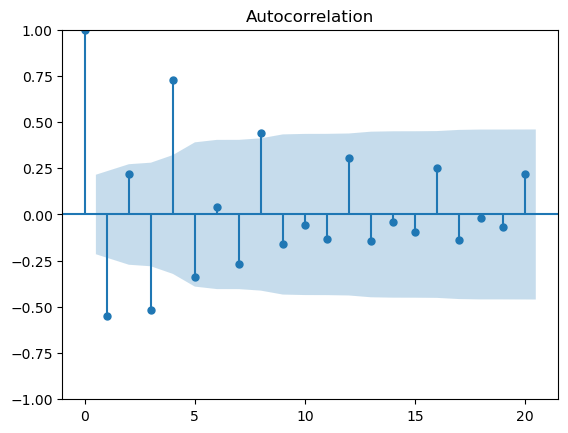

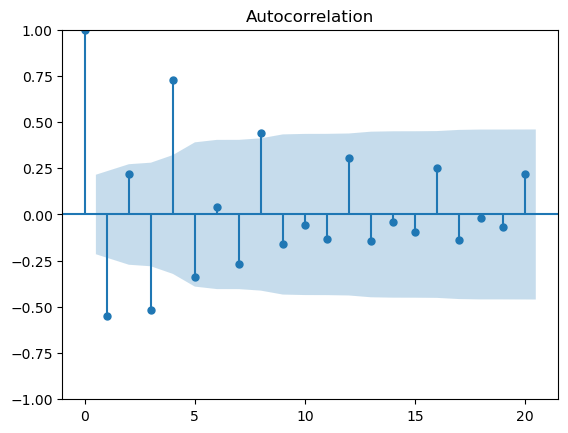

In [36]:
plot_acf(diff_data)

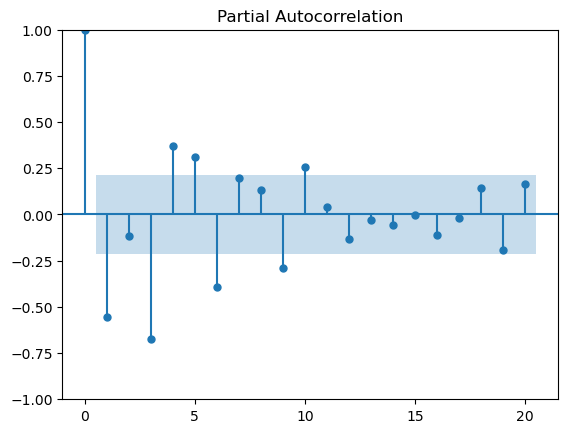

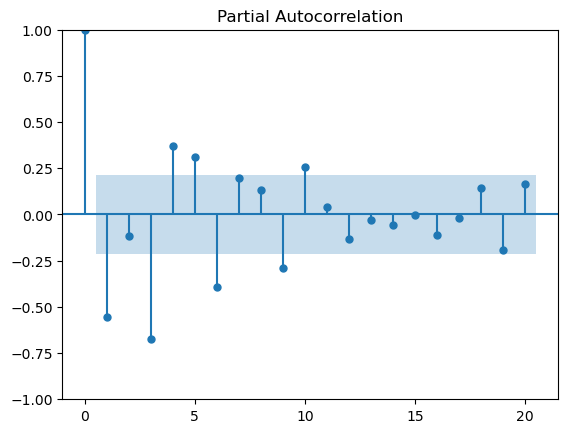

In [37]:
plot_pacf(diff_data)

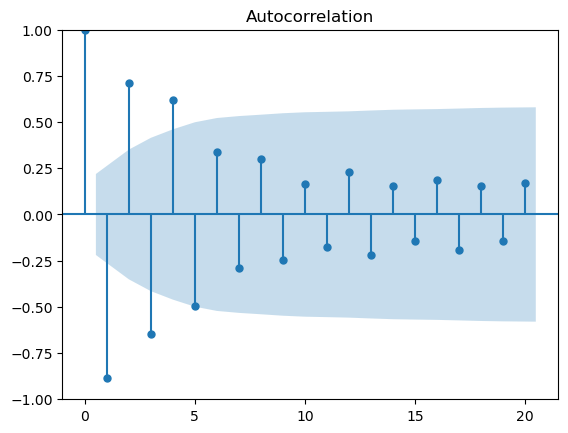

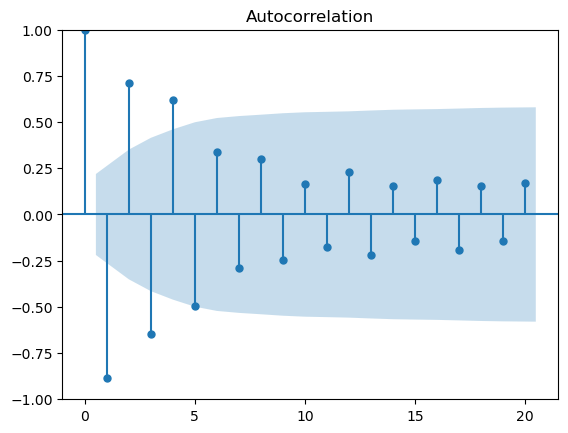

In [38]:
plot_acf(df_diff_seasonal_diff)

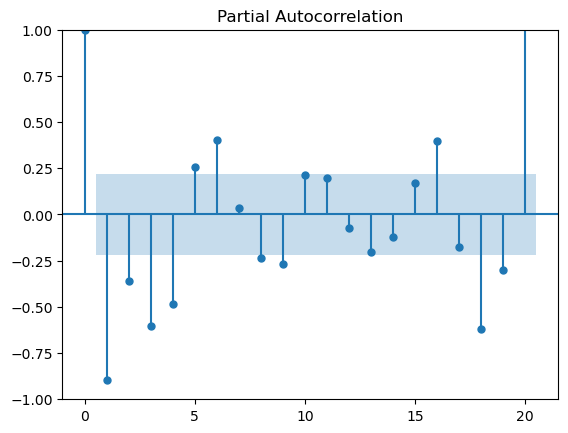

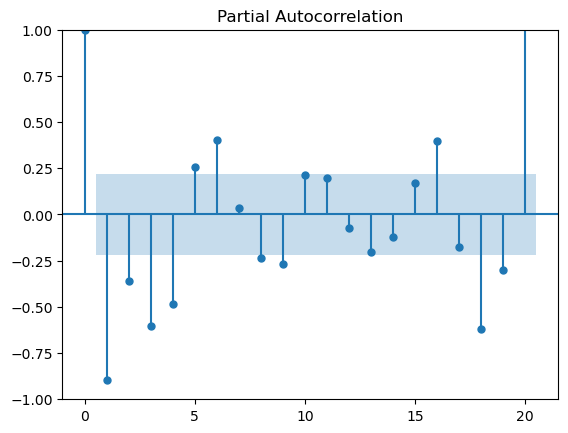

In [39]:
plot_pacf(df_diff_seasonal_diff)

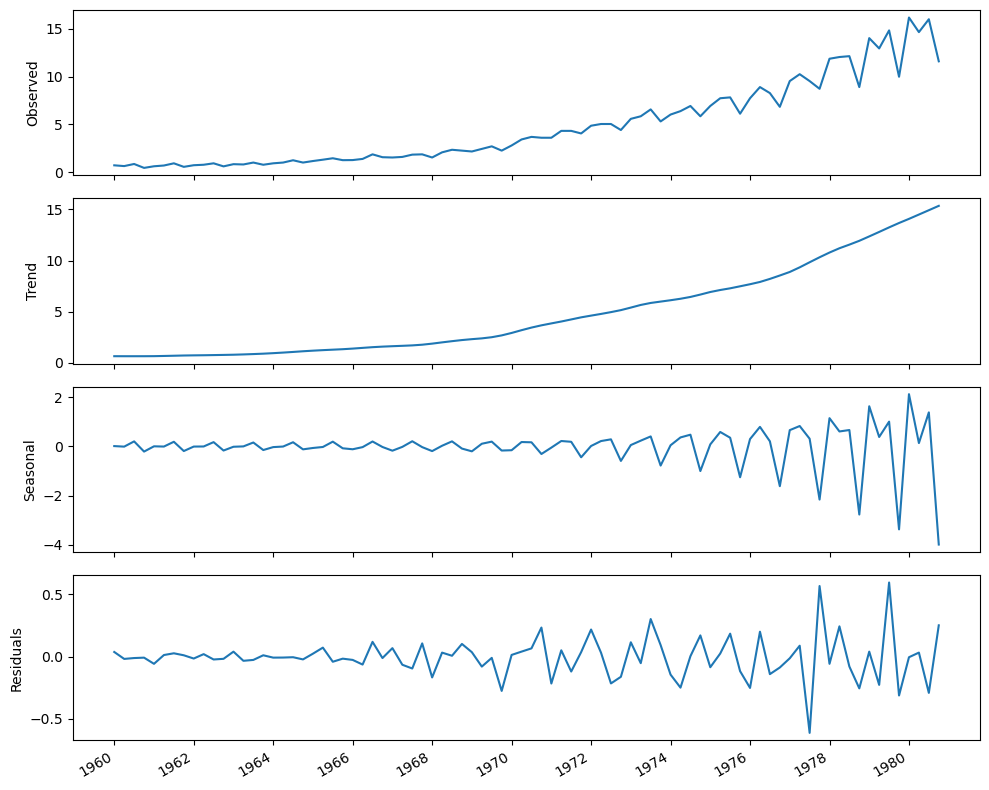

In [40]:
decomposition = STL(data['data'], period=4).fit()    # Period is 4 since we have quarterly data

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [41]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [43]:
train = data[:-4]
test = data[-4:]

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 4   # We have quarterly data, so 4 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.833543
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734026
4,"(2, 2, 0, 0)",90.178107
...,...,...
251,"(0, 0, 3, 2)",136.748820
252,"(0, 0, 2, 3)",136.768920
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947


In [47]:
train = data[:-4]
test = data[-4:]

ps = range(0, 4, 1)
qs = range(0, 4, 1)
# Ps = range(0, 4, 1)
# Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, [0], [0]))

d = 2
D = 0
s = 0   # We have quarterly data, so 4 data points per seasonal cycle

ARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",115.266637
1,"(3, 1, 0, 0)",115.624980
2,"(3, 2, 0, 0)",115.672007
3,"(3, 0, 0, 0)",154.430625
4,"(0, 3, 0, 0)",194.654716
5,"(0, 2, 0, 0)",209.274868
6,"(2, 3, 0, 0)",220.666965
7,"(1, 3, 0, 0)",228.267730
8,"(1, 2, 0, 0)",228.935782
9,"(2, 2, 0, 0)",229.974691


                                      SARIMAX Results                                      
Dep. Variable:                                data   No. Observations:                   80
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 4)   Log Likelihood                 -37.417
Date:                             Wed, 31 May 2023   AIC                             88.834
Time:                                     12:30:59   BIC                            105.056
Sample:                                          0   HQIC                            95.311
                                              - 80                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8194      0.114     -7.164      0.000      -1.044      -0.595
ar.L2         -0.3629      

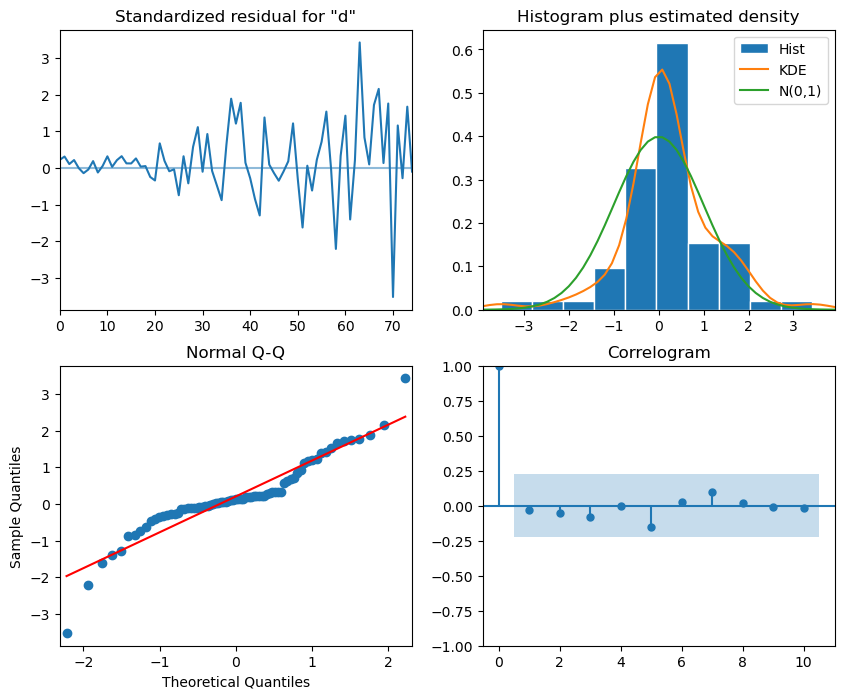

In [49]:
SARIMA_model = SARIMAX(train['data'], order=(3,1,0), seasonal_order=(2,1,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.633
Date:                Wed, 31 May 2023   AIC                            115.267
Time:                        12:31:13   BIC                            131.764
Sample:                             0   HQIC                           121.871
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      0.037    -26.764      0.000      -1.073      -0.926
ar.L2         -0.9882      0.040    -25.002      0.000      -1.066      -0.911
ar.L3         -0.9758      0.026    -37.598      0.0

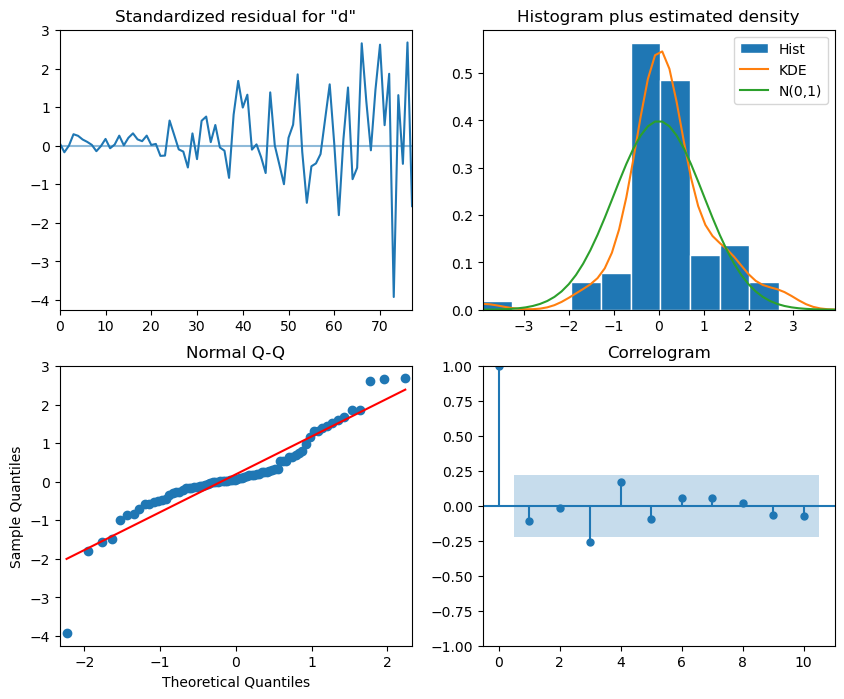

In [50]:
ARIMA_model = SARIMAX(train['data'], order=(3,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

# Resudial valus analysis

In [52]:
residuals = SARIMA_model_fit.resid

value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

value

,lb_stat,lb_pvalue
1,0.088373,0.766255
2,0.260982,0.877664
3,1.110966,0.774428
4,1.137406,0.888293
5,2.879693,0.718527
6,2.969488,0.812667
7,3.825434,0.799650
8,3.883495,0.867479
9,3.888721,0.918583
10,3.911649,0.951245


In [53]:
residuals = ARIMA_model_fit.resid

value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

value

,lb_stat,lb_pvalue
1,1.652020,0.198684
2,1.654544,0.437241
3,7.276173,0.063597
4,9.231226,0.055573
5,9.853425,0.079497
6,10.097125,0.120621
7,10.346926,0.169751
8,10.379005,0.239426
9,10.721222,0.295303
10,11.159917,0.345196


# Get the predictions for SARIMAX

In [54]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,SARIMA_pred
80,1980-01-01,16.20,16.532717
81,1980-04-01,14.67,14.094014
82,1980-07-02,16.02,17.286794
83,1980-10-01,11.61,11.384108


In [55]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_SARIMA)

3.958335161610005


# Get the predictions for ARIMA

In [57]:
ARIMA_pred = ARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,SARIMA_pred,ARIMA_pred
80,1980-01-01,16.20,16.532717,15.858693
81,1980-04-01,14.67,14.094014,14.381508
82,1980-07-02,16.02,17.286794,16.365509
83,1980-10-01,11.61,11.384108,11.680906


In [58]:
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_ARIMA)

1.7102112169997594


we achieved a MAPE of 2.85% with an ARIMA model, while the SARIMA model achieves a MAPE of 3.93%. In this case, the SARIMA model does not perform better on our test set. It can be interesting to have a larger test set and perform rolling forecasts to evaluate both models. However, our dataset is very limited.

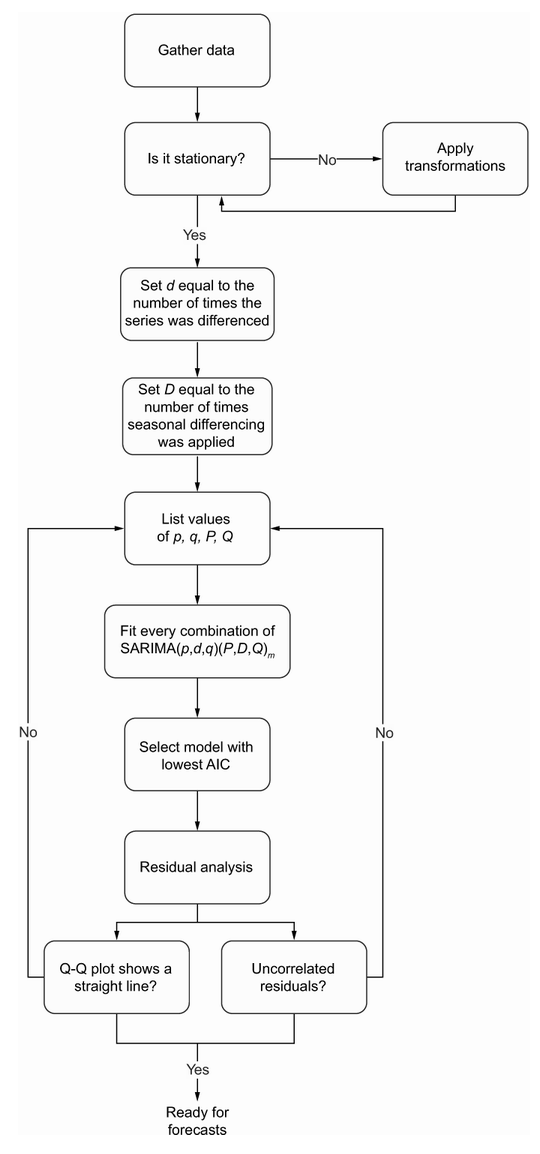